### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

### Load Data

In [2]:
mnist_train = pd.read_csv('datasets/mnist-in-csv/mnist_train.csv')
mnist_test = pd.read_csv('datasets/mnist-in-csv/mnist_test.csv')

In [3]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist_train = mnist_train.dropna()
mnist_test = mnist_test.dropna()

### View Sample
* We will use transpose to change the shape of image tensor<br>
<b>.imshow()</b> needs a 2D array, or a 3D array with the third dimension being of size 3 or 4 only (For RGB or RGBA), so we will shift first axis to last<br>

In [5]:
random_sel = mnist_train.sample(8) # select randomly 8 images

random_sel.shape

(8, 785)

In [6]:
image_features = random_sel.drop('label', axis = 1)

image_batch = (torch.Tensor(image_features.values / 255.)).reshape((-1, 28, 28)) # normalization

image_batch.shape

torch.Size([8, 28, 28])

In [7]:
grid = torchvision.utils.make_grid(image_batch.unsqueeze(1), nrow=8)

grid.shape

torch.Size([3, 32, 242])

(-0.5, 241.5, 31.5, -0.5)

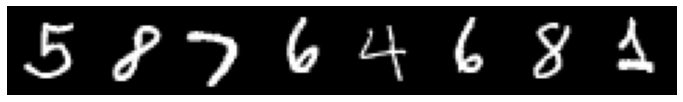

In [8]:
plt.figure (figsize = (12, 12))

plt.imshow(grid.numpy().transpose((1, 2, 0)))

plt.axis('off')

#### Identifying features and labels

In [9]:
mnist_train_features = mnist_train.drop('label', axis =1)
mnist_train_target = mnist_train['label']

mnist_test_features = mnist_test.drop('label', axis =1)
mnist_test_target = mnist_test['label']

#### converting to tensors

In [10]:
X_train_tensor = torch.tensor(mnist_train_features.values, dtype=torch.float)
x_test_tensor  = torch.tensor(mnist_test_features.values, dtype=torch.float) 

Y_train_tensor = torch.tensor(mnist_train_target.values, dtype=torch.long)
y_test_tensor  = torch.tensor(mnist_test_target.values, dtype=torch.long)

In [11]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


#### Reshaping the tensors according to what the CNN needs

In [12]:
# first dimension is the batch,-1 means that it depends on whatever values we set
# second dimension is channel (grayscale)
# third and fourth dimensions are height and width

X_train_tensor = X_train_tensor.reshape(-1, 1, 28, 28) 

x_test_tensor = x_test_tensor.reshape(-1, 1, 28, 28)

In [13]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


### Defining  CNN

In [14]:
import torch.nn as nn
import torch.nn.functional as F

#### Configuring the neural network
* The input size will be the channels of the images (in_size)
* The final output will have a size equal to the number of classes for the prediction
* The convolving kernel will have a size of k_conv_size

In [15]:
# Input size is the number of channels in the input image, for grayscale images this will be 1
in_size = 1

# first convolutional layer has the size of 16, and so on
hid1_size = 16 #Re-run for 32
hid2_size = 32 #Re-run for 64

# final layer, 10 is the total classes
out_size = 10

k_conv_size = 5 #re-run for 3

### Define the Convolutional Neural Network

<b>Conv2d: </b>Applies a 2D convolution over an input signal composed of several input planes.<br>
Parameters<br>
in_channels (int) – Number of channels in the input image<br>
out_channels (int) – Number of channels produced by the convolution<br>
kernel_size (int or tuple) – Size of the convolving kernel<br>

<b>BatchNorm2d: </b>Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .
Parameters<br>
num_features – C from an expected input of size (N,C,H,W)

<b>ReLU: </b>Activation function

<b>Maxpool2d: </b>
Parameters:<br>
kernel_size – the size of the window to take a max over

<b>Linear: </b>
Parameter:<br>

in_features: 
All the operations above used 4D Tensors of shape 

Now for fully connected layers(linear layers) we need to transform them in 1D Tensors<br>
So to the in_features of fully connected layer we will give size
out_features:<br>
num_classes = number of output labels

In [16]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.fc = nn.Linear(512, out_size)
        
 
    def forward(self, x):
        out = self.layer1(x)
        print(out.shape)
        
        out = self.layer2(out)
        print(out.shape)
        
        out = out.reshape(out.size(0), -1)
        print(out.shape)
        
        out = self.fc(out)
        print(out.shape)
        
        ## F.log_softmax(out, dim=-1)
        
        return out

In [17]:
model = ConvNet()

In [18]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [19]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [20]:
X_train_tensor = X_train_tensor.to(device)
x_test_tensor  = x_test_tensor.to(device) 

Y_train_tensor = Y_train_tensor.to(device)
y_test_tensor  = y_test_tensor.to(device)

In [21]:
#Re-run for each different value

learning_rate = 0.001 
#0.01 

criterion = nn.CrossEntropyLoss() 
#nn.NLLLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
#optimizer =torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 
                    

#### Training the model

In [24]:
num_epochs = 10
loss_values = list()

for epoch in range(1, num_epochs):
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs,Y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
    
        print('Epoch - %d, loss - %0.5f '%(epoch, loss.item()))
        loss_values.append(loss.item())


torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 1, loss - 1.48082 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 2, loss - 1.33918 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 3, loss - 1.21874 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 4, loss - 1.11390 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 5, loss - 1.02141 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 6, loss - 0.93939 
torch.Size([60000, 16, 12, 12])
torch.Size([60000, 32, 4, 4])
torch.Size([60000, 512])
torch.Size([60000, 10])
Epoch - 7, loss - 0.86648 
torch.Size([60000, 16, 12, 12])
to

### Model Evaluation

Text(0, 0.5, 'Loss')

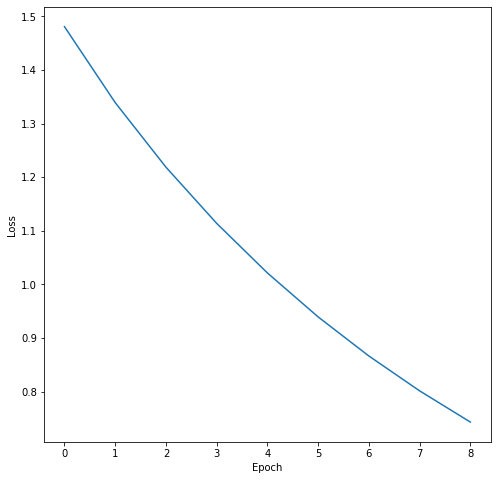

In [25]:
x = (range(0, 9))

plt.figure(figsize = (8, 8))
plt.plot(x, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [26]:
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [28]:
with torch.no_grad():
    
    correct = 0
    total = 0
    
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    y_test = y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()
    
    print("Accuracy: ", accuracy_score(predicted, y_test))
    print("Precision: ", precision_score(predicted, y_test, average='weighted'))
    print("Recall: ", recall_score(predicted, y_test, average='weighted'))

torch.Size([10000, 16, 12, 12])
torch.Size([10000, 32, 4, 4])
torch.Size([10000, 512])
torch.Size([10000, 10])
Accuracy:  0.8582
Precision:  0.8697331646590214
Recall:  0.8582


### Using model for predictions 

In [29]:
print("sample target data = ", mnist_test_target.values[1005])

sample target data =  9


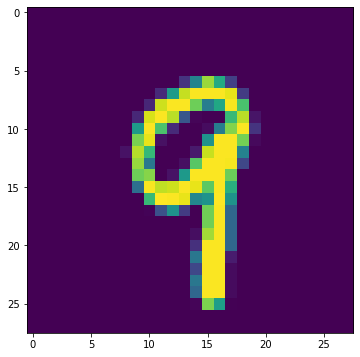

In [30]:
sample_img = mnist_test_features.values[1005]
sample_img = sample_img.reshape(1, 28, 28)

sample_img = sample_img[0, :, :]

plt.figure(figsize =(6, 6))
plt.imshow(sample_img)

In [31]:
sample = np.array(mnist_test_features.values[1005]) 

sample_tensor = torch.from_numpy(sample).float()
sample_tensor = sample_tensor.reshape(-1, 1, 28, 28)
sample_tensor = sample_tensor.to(device)

In [32]:
y_pred = model(sample_tensor)
y_pred

torch.Size([1, 16, 12, 12])
torch.Size([1, 32, 4, 4])
torch.Size([1, 512])
torch.Size([1, 10])


tensor([[-2.5538, -1.4146, -0.7572, -0.0638,  2.5223, -0.6266, -0.7317, -1.0191,
          1.3602,  3.1185]], grad_fn=<AddmmBackward>)

In [33]:
_, predicted = torch.max(y_pred.data, -1)

print (" The predicted label is : ", predicted.item())

 The predicted label is :  9
